<a href="https://colab.research.google.com/github/abishaalichan/abishaalichan/blob/main/Amazon_alexa_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About the Dataset**

This dataset consists of a nearly 3000 Amazon customer reviews (input text), star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots, Alexa Firesticks etc. for learning how to train Machine for sentiment analysis.

**IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LOADING FILE**

In [ ]:
#Loading data
df=pd.read_csv("/content/drive/MyDrive/amazon_alexa.tsv",delimiter='\t',quoting=3) #quoting=3 means no quote is
#treated specially. All quotes are treated as characters.
df.shape

(3150, 5)

In [ ]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


**EXPLORING DATA**

In [ ]:
df.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [ ]:
df.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [ ]:
df.shape

(3150, 5)

In [ ]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [ ]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

In [ ]:
df.dropna(inplace=True)

**Analyzing rating column**

In [ ]:
rating_counts=df['rating'].value_counts() #since 5 rating is the highest and 1 rating,2 rating has very less numbers
#we consider only positive and negative as output i.e, 1 and 2 can be considered as negative reviews and
#3,4 and 5 can be considered as positive reviews. If there was no imbalancing of data, we could have taken
#positive,neutral and negative as output.
rating_counts

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

Text(0.5, 1.0, 'Rating count')

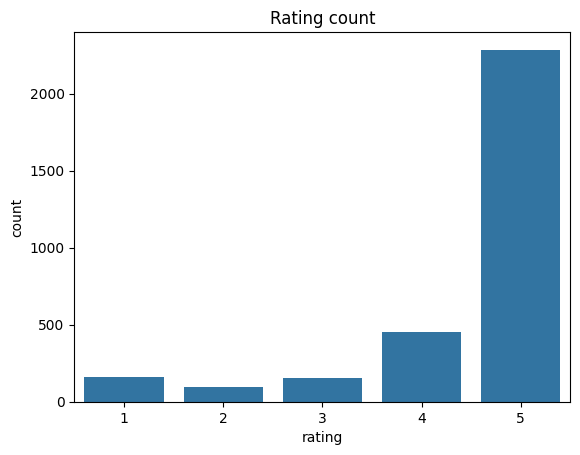

In [ ]:
sns.countplot(x='rating',data=df)
plt.title('Rating count')

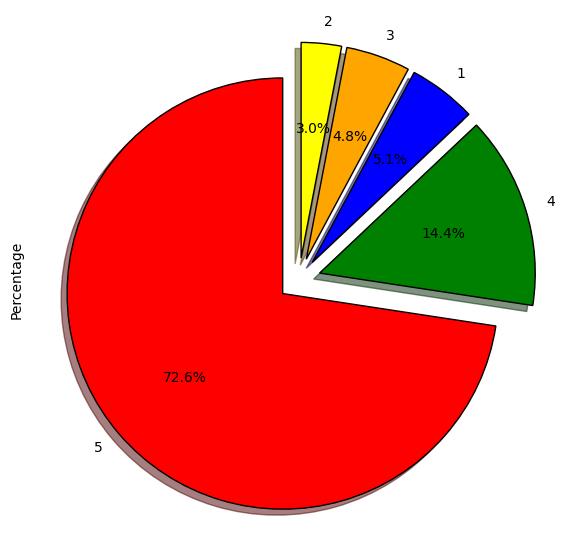

In [ ]:
fig=plt.figure(figsize=(7,7))
colors=('red','green','blue','orange','yellow')
wp={'linewidth':1,'edgecolor':'black'}
tags=df['rating'].value_counts()/df.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie',autopct='%1.1f%%',shadow=True,colors=colors,startangle=90,wedgeprops=wp,explode=explode,label='Percentage')
from io import BytesIO
graph=BytesIO()
fig.savefig(graph,format='png')

**Analyzing feedback column**

In [ ]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

<Axes: xlabel='feedback', ylabel='count'>

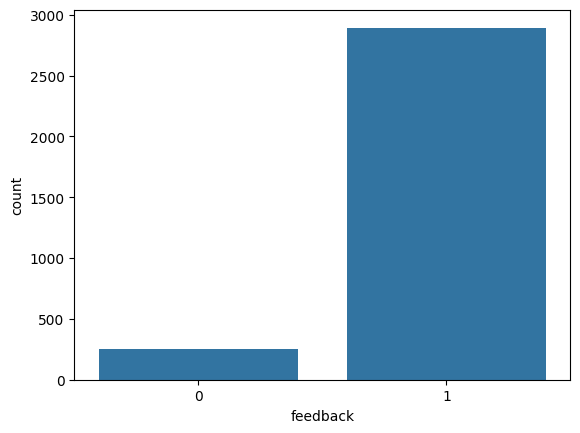

In [ ]:
sns.countplot(x='feedback',data=df)

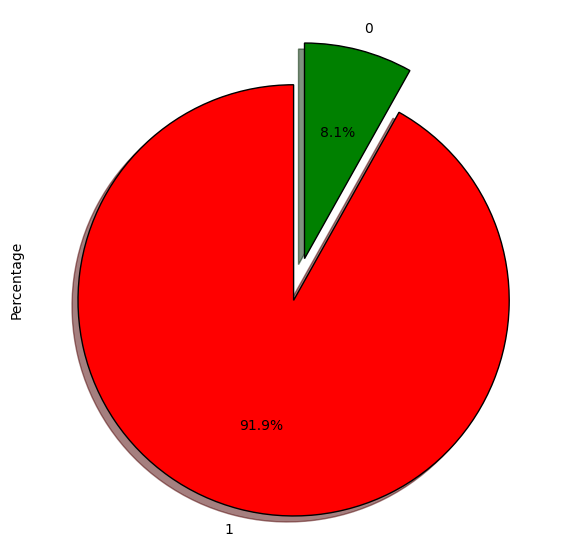

In [ ]:
fig=plt.figure(figsize=(7,7))
colors=('red','green')
wp={'linewidth':1,'edgecolor':'black'}
tags=df['feedback'].value_counts()/df.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie',autopct='%1.1f%%',shadow=True,colors=colors,startangle=90,wedgeprops=wp,explode=explode,label='Percentage')
from io import BytesIO
graph=BytesIO()
fig.savefig(graph,format='png')

In [ ]:
df[df['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [ ]:
df[df['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

If rating of a review if 1 or 2, then the feedback is 0(negative) and if the rating is 3,4 or 5, then the feedback is 1(positive).

([<matplotlib.axis.XTick at 0x7fa173c0d810>,
 [Text(0, 0, 'Black  Dot'),
  Text(1, 0, 'Charcoal Fabric '),
  Text(2, 0, 'Configuration: Fire TV Stick'),
  Text(3, 0, 'Black  Plus'),
  Text(4, 0, 'Black  Show'),
  Text(5, 0, 'Black'),
  Text(6, 0, 'Black  Spot'),
  Text(7, 0, 'White  Dot'),
  Text(8, 0, 'Heather Gray Fabric '),
  Text(9, 0, 'White  Spot'),
  Text(10, 0, 'Sandstone Fabric '),
  Text(11, 0, 'White'),
  Text(12, 0, 'White  Show'),
  Text(13, 0, 'White  Plus'),
  Text(14, 0, 'Oak Finish '),
  Text(15, 0, 'Walnut Finish ')])

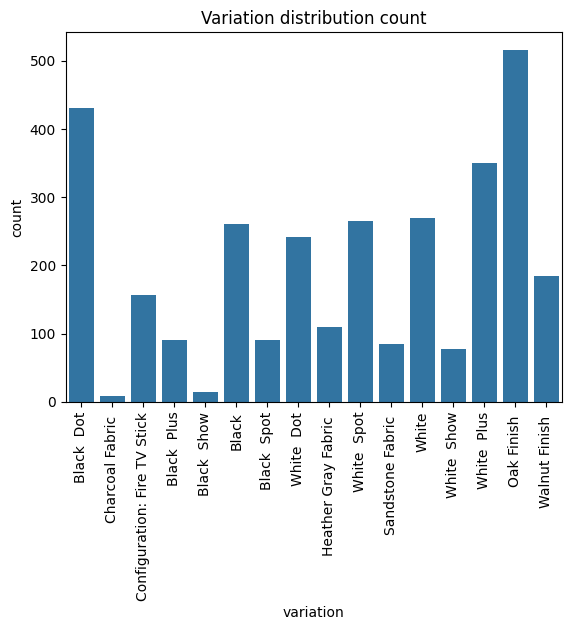

In [ ]:
sns.countplot(x='variation',data=df)
plt.title('Variation distribution count')
tick_labels = df['variation'].value_counts().index
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels,rotation='vertical')

In [ ]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(df.verified_reviews)

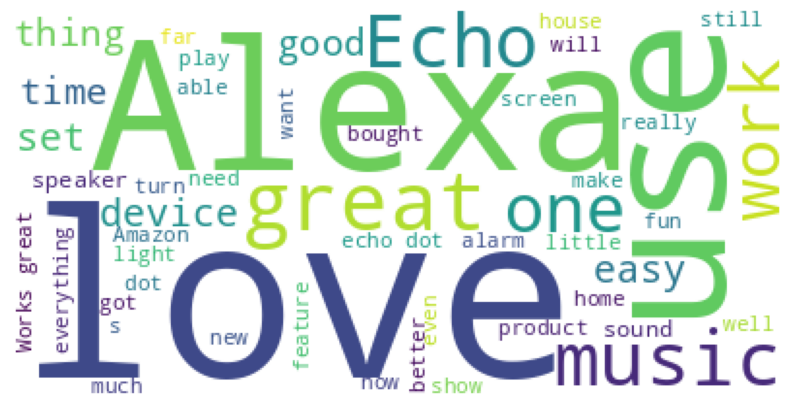

In [ ]:
#combine all reviews
reviews=" ".join([review for review in df['verified_reviews']])

#initialize wordcloud object
wc=WordCloud(background_color='white',max_words=50)

#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.show()

To build the corpus of the 'verified_reviews' we perform the following :

1.Replace any non-alphabet characters with a space

2.Convert into lower case and split into words

3.Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus.

In [ ]:
corpus=[]
sw = stopwords.words('english')
stemmer = PorterStemmer()
for i in range(0,df.shape[0]):
  review = re.sub('[^a-zA-Z]',' ',df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in sw]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
#vectorization
cv = CountVectorizer(max_features=2500)
x=cv.fit_transform(corpus).toarray()
y=df['feedback'].values

In [ ]:
import os
#creating 'Models' directory
if not os.path.exists('Models'):
    os.makedirs('Models')
#saving the count vectorizer
pickle.dump(cv,open('Models/countVectorizer.pkl','wb'))

In [ ]:
print(x.shape)
print(y.shape)

(3149, 2500)
(3149,)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=15)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2204, 2500)
(945, 2500)
(2204,)
(945,)


In [ ]:
#normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
pickle.dump(scaler,open('Models/scaler.pkl','wb'))

**RANDOM FOREST CLASSIFIER**

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[ 34  44]
 [  5 862]]


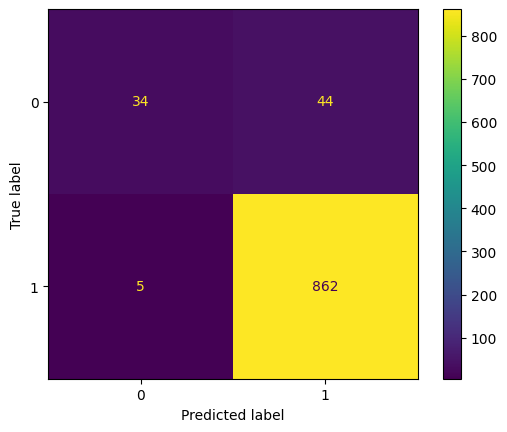

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
cm_display.plot()
plt.show()

In [ ]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.9481481481481482
